### Download the dataset

In [ ]:
import os
import shutil
try:
    shutil.rmtree("/content/hi")
except:
    pass

try:
    os.remove("/content/hi.zip")
except:
    pass

try:
    shutil.rmtree("/content/wandb")
except:
    pass

In [ ]:
%%capture
!gdown https://drive.google.com/uc?id=1TkaNm9ucnEn3S5Pz3D5SRFiroFgx4fjs
!unzip "/content/hi.zip"
!pip install wandb

In [ ]:
!nvidia-smi

Mon May 10 11:55:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from wandb.keras import WandbCallback

### Load the data

In [ ]:
# Load the training lexicons
with open("hi/lexicons/hi.translit.sampled.train.tsv") as f:
    training_lines = f.readlines()
training_pairs = [line.strip("\n").split("\t") for line in training_lines]
training_map = dict([(example[1], example[0]) for example in training_pairs])

# Load the validation lexicons
with open("hi/lexicons/hi.translit.sampled.dev.tsv") as f:
    validation_lines = f.readlines()
validation_pairs = [line.strip("\n").split("\t") for line in validation_lines]
validation_map = dict([(example[1], example[0]) for example in validation_pairs])

# Load the test lexicons
with open("hi/lexicons/hi.translit.sampled.test.tsv") as f:
    test_lines = f.readlines()
test_pairs = [line.strip("\n").split("\t") for line in test_lines]
test_map = dict([(example[1], example[0]) for example in test_pairs])

# Number of training examples
M_train = len(training_map.keys())

# Number of validation examples
M_val = len(validation_map.keys())

# Number of test examples
M_test = len(test_map.keys())

print(f"Number of training examples = {M_train}")
print(f"Number of validation examples = {M_val}")
print(f"Number of test examples = {M_test}")
print()

Number of training examples = 41345
Number of validation examples = 4321
Number of test examples = 4442



### Prepare the data

We have used "tab" for the START sequence character and "newline" as the END sequence character.

In [ ]:
def extract_data_info(data_dict):
    """
    Returns important information about the data.
    """
    input_words = []
    target_words = []
    input_characters = []
    target_characters = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")
        # Add the characters to the respective character lists
        input_characters = list(set(input_characters + list(key)))
        target_characters = list(set(target_characters + list(data_dict[key])))

    # Sort the input characters
    input_characters = sorted(list(set(input_characters)))
    # Sort the target characters
    target_characters = target_characters + ["\t", "\n"]
    target_characters = sorted(list(set(target_characters)))

    # Number of unique tokens in the source language
    num_input_tokens = len(input_characters)
    # Number of unique tokens in the target language
    num_target_tokens = len(target_characters)

    # Max input word length
    max_encoder_seq_length = max([len(word) for word in input_words])
    # Max output word length
    max_decoder_seq_length = max([len(word) for word in target_words])

    print(f"Number of unique input characters: {num_input_tokens}")
    print(f"Number of unique output characters: {num_target_tokens}")
    print()
    print(f"Maximum sequence length for the input: {max_encoder_seq_length}")
    print(f"Maximum sequence length for the output: {max_decoder_seq_length}")

    # Map characters to numerical indices (using +1 to avoid any character being mapped to 0)
    input_char_map = dict([(ch, i + 1) for i, ch in enumerate(input_characters)])
    target_char_map = dict([(ch, i + 1) for i, ch in enumerate(target_characters)])

    return input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map

def make_one_hot_arrays(data_dict, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens):
    """
    This function takes the training/validation/test dictionary as input and produces
    the one-hot encoded versions of the respective data.
    """
    input_words = []
    target_words = []

    for key in data_dict:
        # Store the word in the source language
        input_words.append(key)
        # Store the word in the target language
        target_words.append("\t"+data_dict[key]+"\n")

    M = len(data_dict.keys())
    encoder_input_array = np.zeros((M, max_encoder_seq_length, num_input_tokens + 1), dtype="float")
    decoder_input_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")
    decoder_output_array = np.zeros((M, max_decoder_seq_length, num_target_tokens + 1), dtype="float")

    for i in range(M):
        source_word = input_words[i]
        target_word = target_words[i]

        # One-hot encoding for the input
        for j, ch in enumerate(source_word):
            encoder_input_array[i, j, input_char_map[ch]] = 1.0

        # One-hot encoding for the output
        for j, ch in enumerate(target_word):
            decoder_input_array[i, j, target_char_map[ch]]= 1.0
            if j >= 1:
                # The decoder output is one step ahead of the decoder input
                decoder_output_array[i, j-1, target_char_map[ch]] = 1.0

    return input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array

In [ ]:
input_characters, target_characters, num_input_tokens, num_target_tokens, max_encoder_seq_length, max_decoder_seq_length, input_char_map, target_char_map = extract_data_info(training_map)

Number of unique input characters: 26
Number of unique output characters: 64

Maximum sequence length for the input: 20
Maximum sequence length for the output: 21


In [ ]:
# Get the one-hot training matrices
input_words, target_words, encoder_input_array, decoder_input_array, decoder_output_array = make_one_hot_arrays(training_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_encoder_input_array = keras.preprocessing.sequence.pad_sequences(encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_decoder_input_array = keras.preprocessing.sequence.pad_sequences(decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_decoder_output_array = keras.preprocessing.sequence.pad_sequences(decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_decoder_output_array_oh = np.zeros((padded_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_decoder_output_array_oh[i][j][padded_decoder_output_array[i][j]] = 1.0

In [ ]:
# Get the one-hot validation matrices
val_input_words, val_target_words, val_encoder_input_array, val_decoder_input_array, val_decoder_output_array = make_one_hot_arrays(validation_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_val_encoder_input_array = keras.preprocessing.sequence.pad_sequences(val_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_val_decoder_input_array = keras.preprocessing.sequence.pad_sequences(val_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_val_decoder_output_array = keras.preprocessing.sequence.pad_sequences(val_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_val_decoder_output_array_oh = np.zeros((padded_val_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_val_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_val_decoder_output_array_oh[i][j][padded_val_decoder_output_array[i][j]] = 1.0

In [ ]:
# Get the one-hot validation matrices
test_input_words, test_target_words, test_encoder_input_array, test_decoder_input_array, test_decoder_output_array = make_one_hot_arrays(test_map, max_encoder_seq_length, max_decoder_seq_length, num_input_tokens, num_target_tokens)

# # Pad sequences
# padded_test_encoder_input_array = keras.preprocessing.sequence.pad_sequences(test_encoder_input_array, padding="post", maxlen=max_encoder_seq_length)
# padded_test_decoder_input_array = keras.preprocessing.sequence.pad_sequences(test_decoder_input_array, padding="post", maxlen=max_decoder_seq_length)
# padded_test_decoder_output_array = keras.preprocessing.sequence.pad_sequences(test_decoder_output_array, padding="post", maxlen=max_decoder_seq_length)

# # Decoder output should be one hot
# padded_test_decoder_output_array_oh = np.zeros((padded_test_decoder_output_array.shape[0], max_decoder_seq_length, num_target_tokens), dtype="float")
# for i in range(padded_test_decoder_output_array.shape[0]):
#     for j in range(max_decoder_seq_length):
#         padded_test_decoder_output_array_oh[i][j][padded_test_decoder_output_array[i][j]] = 1.0

In [ ]:
# Using label encoding for the encoder inputs (and then find an embedding using the Embedding layer)
encoder_input_array = np.argmax(encoder_input_array, axis=2)
val_encoder_input_array = np.argmax(val_encoder_input_array, axis=2)
test_encoder_input_array = np.argmax(test_encoder_input_array, axis=2)

decoder_input_array = np.argmax(decoder_input_array, axis=2)
val_decoder_input_array = np.argmax(val_decoder_input_array, axis=2)
test_decoder_input_array = np.argmax(test_decoder_input_array, axis=2)

# Dictionaries mapping from indices to characters
reverse_input_char_map = dict((i, char) for char, i in input_char_map.items())
reverse_target_char_map = dict((i, char) for char, i in target_char_map.items())
reverse_target_char_map[0] = "\n"

### Define the model

In [ ]:
def define_model(num_cells, cell_type, num_encoder_layers, num_decoder_layers, input_embedding_size, dropout_fraction, beam_size):
    """
    num_cells: Number of cells in the encoder and decoder layers
    cell_type: choice of cell type: Simple RNN, LSTM, GRU
    num_encoder_layers: Number of layers in the encoder
    num_decoder_layers: Number of layers in the decoder
    input_embedding_size: Dimenions of the vector to represent each character
    dropout_fraction: fraction of neurons to drop out
    """
    ## ENCODER
    # encoder_input = keras.Input(shape=(None, num_input_tokens), name="EncoderInput")
    encoder_input = keras.Input(shape=(None, ), name="EncoderInput")
    encoder_embedding = keras.layers.Embedding(num_input_tokens + 1, input_embedding_size, name="EncoderInputEmbedding", mask_zero=True)(encoder_input)

    # LSTM/RNN/GRU layer of the encoder
    for i in range(1, num_encoder_layers+1):
        if cell_type=="LSTM":
            if i==num_encoder_layers:
                encoder = keras.layers.LSTM(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.LSTM(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)

            if i==1:
                encoder_outputs, encoder_state_h_1, encoder_state_c_1 = encoder(encoder_embedding)
            if i==2:
                encoder_outputs, encoder_state_h_2, encoder_state_c_2 = encoder(encoder_outputs)
            if i==3:
                encoder_outputs, encoder_state_h_3, encoder_state_c_3 = encoder(encoder_outputs)

        if cell_type=="RNN":
            if i==num_encoder_layers:
                encoder = keras.layers.SimpleRNN(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.SimpleRNN(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                whole_sequence_output, rnn_final_state_1 = encoder(encoder_embedding)
            if i==2:
                whole_sequence_output, rnn_final_state_2 = encoder(whole_sequence_output)
            if i==3:
                whole_sequence_output, rnn_final_state_3 = encoder(whole_sequence_output)

        if cell_type=="GRU":
            if i==num_encoder_layers:
                encoder = keras.layers.GRU(num_cells, return_state=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            else:
                encoder = keras.layers.GRU(num_cells, return_state=True, return_sequences=True, name="EncoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                whole_sequence_output, gru_final_state_1 = encoder(encoder_embedding)
            if i==2:
                whole_sequence_output, gru_final_state_2 = encoder(whole_sequence_output)
            if i==3:
                whole_sequence_output, gru_final_state_3 = encoder(whole_sequence_output)


    ## DECODER
    decoder_input = keras.Input(shape=(None, ), name="DecoderInput")
    decoder_embedding = keras.layers.Embedding(num_target_tokens + 1, 64, name="DecoderInputEmbedding", mask_zero=True)(decoder_input)


    for i in range(1, num_decoder_layers+1):
        if cell_type=="LSTM":
            decoder_lstm = keras.layers.LSTM(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embedding, initial_state = [encoder_state_h_1, encoder_state_c_1])
            if i==2:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_outputs, initial_state = [encoder_state_h_2, encoder_state_c_2])
            if i==3:
                decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_outputs, initial_state = [encoder_state_h_3, encoder_state_c_3])
                

        if cell_type=="RNN":
            decoder_rnn = keras.layers.SimpleRNN(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_embedding, initial_state = rnn_final_state_1)
            if i==2:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_outputs, initial_state = rnn_final_state_2)
            if i==3:
                decoder_outputs, rnn_decoder_final_state = decoder_rnn(decoder_outputs, initial_state = rnn_final_state_3)

        if cell_type=="GRU":
            decoder_gru = keras.layers.GRU(num_cells, return_sequences=True, return_state=True, name="DecoderLayer"+str(i), dropout=dropout_fraction, recurrent_dropout=dropout_fraction)
            if i==1:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_embedding, initial_state = gru_final_state_1)
            if i==2:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_outputs, initial_state = gru_final_state_2)
            if i==3:
                decoder_outputs, gru_decoder_final_state = decoder_gru(decoder_outputs, initial_state = gru_final_state_3)

    decoder_dense = keras.layers.Dense(num_target_tokens + 1, activation="softmax", name="DecoderDenseLayer") # Softmax picks one character
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = keras.Model([encoder_input, decoder_input], decoder_outputs)

    return model

# Inference Functions

### Inference, LSTM, 1 Decoder Layer

In [ ]:
def prepare_inference_model_lstm_1(model, num_cells):
        """
    Inference for LSTM model with 1 encoder layers and 1 decoder layers.
    """
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]
    # Output of the encoder
    for layer in model.layers:
        if "EncoderLayer" in layer.name:
            _, state_h_enc, state_c_enc = layer.output
    encoder_states = [state_h_enc, state_c_enc]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]
    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if "DecoderLayer1" in layer.name:
            decoder_lstm_first = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer


    decoder_state_input_h = keras.Input(shape=(num_cells,))
    decoder_state_input_c = keras.Input(shape=(num_cells,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm_first(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs)
    decoder_states = [state_h_dec, state_c_dec]

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return encoder_model, decoder_model


def transliterate_word_lstm_1(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h, c = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = [h, c]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

IndentationError: ignored

### Inference: LSTM, 2 Decoder Layers

In [ ]:
def prepare_inference_model_lstm_2(model, num_cells):
    """
    Inference for LSTM model with 2 encoder layers and 2 decoder layers.
    """
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_h_enc_1, state_c_enc_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_h_enc_2, state_c_enc_2 = layer.output
    encoder_states = [state_h_enc_1, state_c_enc_1, state_h_enc_2, state_c_enc_2]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_state_input_h_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_2 = keras.Input(shape=(num_cells,))
    decoder_states_inputs_1 = [decoder_state_input_h_1, decoder_state_input_c_1]
    decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]

    decoder_outputs, state_h_dec_1, state_c_dec_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs_1)
    decoder_outputs, state_h_dec_2, state_c_dec_2 = decoder_2(decoder_outputs, initial_state = decoder_states_inputs_2)


    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs_1 + decoder_states_inputs_2,
                                [decoder_outputs] + [state_h_dec_1, state_c_dec_1, state_h_dec_2, state_c_dec_2])
    
    return encoder_model, decoder_model

def transliterate_word_lstm_2(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h1, c1, h2, c2 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [h1, c1, h2, c2]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

### Inference: LSTM, 3 Decoder Layers

In [ ]:
def prepare_inference_model_lstm_3(model, num_cells):
    """
    Inference for LSTM model with 3 encoder layers and 3 decoder layers.
    """
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_h_enc_1, state_c_enc_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_h_enc_2, state_c_enc_2 = layer.output
        if layer.name =="EncoderLayer3":
            _, state_h_enc_3, state_c_enc_3 = layer.output

    encoder_states = [state_h_enc_1, state_c_enc_1, state_h_enc_2, state_c_enc_2, state_h_enc_3, state_c_enc_3]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_state_input_h_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_1 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_2 = keras.Input(shape=(num_cells,))
    decoder_state_input_h_3 = keras.Input(shape=(num_cells,))
    decoder_state_input_c_3 = keras.Input(shape=(num_cells,))

    decoder_states_inputs_1 = [decoder_state_input_h_1, decoder_state_input_c_1]
    decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]
    decoder_states_inputs_3 = [decoder_state_input_h_3, decoder_state_input_c_3]

    decoder_outputs, state_h_dec_1, state_c_dec_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=decoder_states_inputs_1)
    decoder_outputs, state_h_dec_2, state_c_dec_2 = decoder_2(decoder_outputs, initial_state = decoder_states_inputs_2)
    decoder_outputs, state_h_dec_3, state_c_dec_3 = decoder_3(decoder_outputs, initial_state = decoder_states_inputs_3)


    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)
    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs_1 + decoder_states_inputs_2 + decoder_states_inputs_3,
                                [decoder_outputs] + [state_h_dec_1, state_c_dec_1, state_h_dec_2, state_c_dec_2,state_h_dec_3, state_c_dec_3])
    
    return encoder_model, decoder_model

def transliterate_word_lstm_3(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, h1, c1, h2, c2, h3, c3 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [h1, c1, h2, c2, h3, c3]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

### Inference for RNN and GRU


In [ ]:
def prepare_inference_model_rnngru_1(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]
    # Output of the encoder
    for layer in model.layers:
        if "EncoderLayer" in layer.name:
            _, state = layer.output
    encoder_states = [state]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]
    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if "DecoderLayer1" in layer.name:
            decoder_rnn_first = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer

    decoder_states_inputs = keras.Input(shape=(num_cells, ))
    decoder_outputs, decoder_states = decoder_rnn_first(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs], [decoder_outputs] + [decoder_states])

    return encoder_model, decoder_model


def transliterate_word_rnngru_1(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state = decoder_model.predict([target_sequence] + [encoded_hidden_cell_states])

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden state and cell state 
        encoded_hidden_cell_states = [state]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

In [ ]:
def prepare_inference_model_rnngru_2(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_2 = layer.output

    encoder_states = [state_1, state_2]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer

    decoder_states_inputs_1 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_2 = keras.Input(shape=(num_cells, ))

    decoder_outputs, decoder_states_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs_1])
    decoder_outputs, decoder_states_2 = decoder_2(decoder_outputs, initial_state=[decoder_states_inputs_2])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs_1, decoder_states_inputs_2],
                                [decoder_outputs] + [decoder_states_1, decoder_states_2])
    
    return encoder_model, decoder_model

def transliterate_word_rnngru_2(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state_1, state_2 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [state_1, state_2]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    
    return decoded_words

In [ ]:
def prepare_inference_model_rnngru_3(model, num_cells):
    # Input to the encoder, sequence of characters (word) in the source language
    encoder_inputs = model.input[0]

    # Output of the encoder
    for layer in model.layers:
        if layer.name =="EncoderLayer1":
            _, state_1 = layer.output
        if layer.name =="EncoderLayer2":
            _, state_2 = layer.output
        if layer.name =="EncoderLayer3":
            _, state_3 = layer.output

    encoder_states = [state_1, state_2, state_3]

    # Create an encoder model which outputs only cell states
    encoder_model = keras.Model(encoder_inputs, encoder_states)

    # Input to the decoder
    decoder_inputs = model.input[1]

    for layer in model.layers:
        if layer.name=="DecoderDenseLayer":
            decoder_dense = layer
        if layer.name == "DecoderInputEmbedding":
            decoder_embedding_layer = layer
        if layer.name == "DecoderLayer1":
            decoder_1 = layer
        if layer.name == "DecoderLayer2":
            decoder_2 = layer
        if layer.name == "DecoderLayer3":
            decoder_3 = layer

    decoder_states_inputs_1 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_2 = keras.Input(shape=(num_cells, ))
    decoder_states_inputs_3 = keras.Input(shape=(num_cells, ))

    decoder_outputs, decoder_states_1 = decoder_1(decoder_embedding_layer(decoder_inputs), initial_state=[decoder_states_inputs_1])
    decoder_outputs, decoder_states_2 = decoder_2(decoder_outputs, initial_state=[decoder_states_inputs_2])
    decoder_outputs, decoder_states_3 = decoder_3(decoder_outputs, initial_state=[decoder_states_inputs_3])

    # Softmax layer
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the decoder model
    decoder_model = keras.Model([decoder_inputs] + [decoder_states_inputs_1, decoder_states_inputs_2, decoder_states_inputs_3],
                                [decoder_outputs] + [decoder_states_1, decoder_states_2, decoder_states_3])
    
    return encoder_model, decoder_model

def transliterate_word_rnngru_3(input_words, encoder_model, decoder_model):
    """
    Decodes the given input sequence, one character at a time.
    """
    # Get batch_size
    batch_size = input_words.shape[0]
    # Encode the input string
    encoded_hidden_cell_states = encoder_model.predict(input_words)

    target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))
    # Set the first character to "tab" as it is the start of sequence character
    target_sequence[:, 0, target_char_map["\t"]] = 1.0
    target_sequence = np.argmax(target_sequence, axis=2)

    decoded_words = [""]*batch_size
    for i in range(max_decoder_seq_length):
        output_tokens, state_1, state_2, state_3 = decoder_model.predict([target_sequence] + encoded_hidden_cell_states)

        # Sample the most probable character using softmax outputs
        sampled_char_indices = np.argmax(output_tokens[:, -1, :], axis=1)

        # Update the target sequence which goes back as input to the decoder.
        target_sequence = np.zeros((batch_size, 1, num_target_tokens+1))

        for j, ch_index in enumerate(sampled_char_indices):
            decoded_words[j] += reverse_target_char_map[ch_index]
            target_sequence[j, 0, ch_index] = 1.0

        target_sequence = np.argmax(target_sequence, axis=2)

        # Update the hidden states and cell states 
        encoded_hidden_cell_states = [state_1, state_2, state_3]

    # To remove the \n chars
    decoded_words = [word[:word.find("\n")] for word in decoded_words]
    return decoded_words

# Training the Best Model

Use this to train the model with the best choice of hyperparameters obtained from Wandb.

In [ ]:
def train(num_cells, cell_type, num_layers, input_embedding_size, dropout_fraction, beam_size):
    """
    Function to train the model with the best set of hyperparameters (without WANDB)
    """
    # Define the model

    model = define_model(num_cells, cell_type, num_layers, num_layers, input_embedding_size, dropout_fraction, beam_size)
    print(model.summary())

    # Compile the model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
            [encoder_input_array, decoder_input_array],
            decoder_output_array,
            batch_size = 64,
            epochs = 20,
            verbose = 2,
            validation_data = ([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
            )

    # Save the trained model
    model.save("best_model_seq2seq.h5")

    if cell_type == "LSTM":
        cell = "lstm"
    else:
        cell = "rnngru"

    func1_name = "prepare_inference_model_" + cell + "_" + str(num_layers)
    func2_name = "transliterate_word_" + cell + "_" + str(num_layers)

    # Get the encoder and decoder model
    encoder_model, decoder_model = globals()[func1_name](model, num_cells)

    outputs = []
    n = encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in target_words]
    # Calculate training accuracy
    training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Training accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))


    outputs = []
    n = val_encoder_input_array.shape[0]
    batch_size = 1000
    for i in range(0, n, batch_size):
        # Inputs
        query = val_encoder_input_array[i:i+batch_size]
        # Results
        decoded_words = globals()[func2_name](query, encoder_model, decoder_model)
        outputs = outputs + decoded_words

    # To remove the tab and newline characters from the ground truth
    ground_truths = [word[1:-1] for word in val_target_words]
    # Calculate validation accuracy
    validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
    print("Validation accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

    # Plots of accuracy and loss
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.plot(history.history["accuracy"], label = "Training accuracy")
    plt.title("Accuracy vs epoch", size=14)
    plt.legend()
    plt.show()

    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.plot(history.history["loss"], label = "Training loss")
    plt.title("Loss vs epoch", size=14)
    plt.legend()
    plt.show()

    return model, history

### Training with the Best Hyperparameters

These are the best hyperparameters that we got from WANDB.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
EncoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
DecoderInput (InputLayer)       [(None, None)]       0                                            
__________________________________________________________________________________________________
EncoderInputEmbedding (Embeddin (None, None, 32)     864         EncoderInput[0][0]               
__________________________________________________________________________________________________
DecoderInputEmbedding (Embeddin (None, None, 64)     4160        DecoderInput[0][0]               
______________________________________________________________________________________________

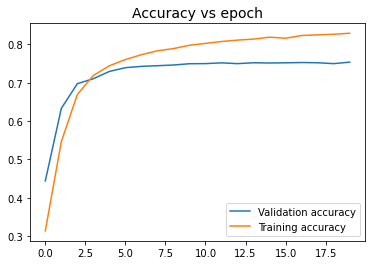

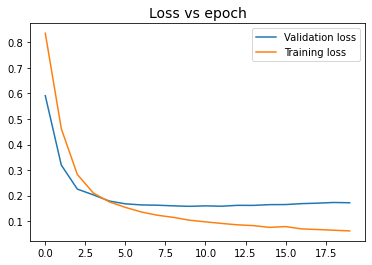

In [ ]:
# Best hyperparameters
num_cells = 256
cell_type = "GRU"
num_layers = 2
num_encoder_layers = num_layers
num_decoder_layers = num_layers
input_embedding_size = 32
dropout_fraction = 0.1
beam_size = 1

model, history = train(num_cells, cell_type, num_layers, input_embedding_size, dropout_fraction, beam_size)

### Load the best model



In [ ]:
model = keras.models.load_model("best_model_seq2seq.h5")
encoder_model, decoder_model = prepare_inference_model_rnngru_2(model, num_cells)

### Diagram of the Best Model

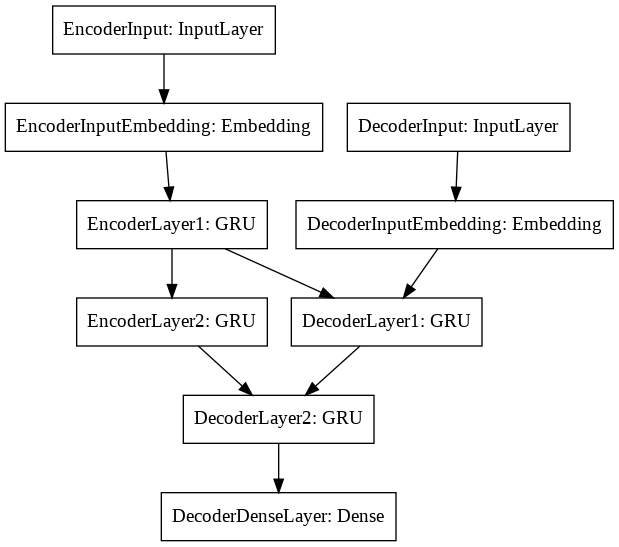

In [ ]:
keras.utils.plot_model(model)

### Character-wise accuracy scores

In [ ]:
train_eval = model.evaluate([encoder_input_array, decoder_input_array], decoder_output_array)
val_eval = model.evaluate([val_encoder_input_array, val_decoder_input_array], val_decoder_output_array)
test_eval = model.evaluate([test_encoder_input_array, test_decoder_input_array], test_decoder_output_array)

print("Character-wise training accuracy = {} %".format(train_eval[1]*100.0))
print("Character-wise validation accuracy = {} %".format(val_eval[1]*100.0))
print("Character-wise test accuracy = {} %".format(test_eval[1]*100.0))

139/139 [==============================] - 6s 41ms/step - loss: 0.1694 - accuracy: 0.7517
Character-wise training accuracy = 85.83393692970276 %
Character-wise validation accuracy = 75.37280917167664 %
Character-wise test accuracy = 75.17355680465698 %


### Inference using the best model (Training Set)

In [ ]:
outputs = []

n = encoder_input_array.shape[0]
batch_size = 1000

for i in range(0, n, batch_size):
    # Inputs
    query = encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_rnngru_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in target_words[:n]]

df_train = pd.DataFrame({"Input": input_words[:n], "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate training accuracy
training_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Training Inference accuracy based on whole string matching = {} %".format(training_inference_accuracy*100.0))

# Save the inference results
df_train.to_csv("TrainingSetPredictions.csv", index=False)

Training Inference accuracy based on whole string matching = 83.71991776514693 %


### Inference using the best model (Validation Set)

In [ ]:
outputs = []

n = val_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = val_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_rnngru_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in val_target_words]

df_val = pd.DataFrame({"Input": val_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate validation accuracy
validation_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Validation set inference accuracy based on whole string matching = {} %".format(validation_inference_accuracy*100.0))

# Save the inference results
df_val.to_csv("ValidationSetPredictions.csv", index=False)

Validation set inference accuracy based on whole string matching = 38.60217542235594 %


### Inference using the best model (Test Set)

In [ ]:
outputs = []

n = test_encoder_input_array.shape[0]

batch_size = 1000
for i in range(0, n, batch_size):
    # Inputs
    query = test_encoder_input_array[i:i+batch_size]
    # Results
    decoded_words = transliterate_word_rnngru_2(query, encoder_model, decoder_model)
    outputs = outputs + decoded_words

# To remove the tab and newline characters from the ground truth
ground_truths = [word[1:-1] for word in test_target_words]

df_test = pd.DataFrame({"Input": test_input_words, "Ground Truth" : ground_truths, "Model output":outputs})

# Calculate validation accuracy
test_inference_accuracy = np.mean(np.array(outputs) == np.array(ground_truths))
print("Test set Inference accuracy based on whole string matching = {} %".format(test_inference_accuracy*100.0))

# Save the inference results
df_test.to_csv("TestSetPredictions.csv", index=False)

Test set Inference accuracy based on whole string matching = 37.57316524088248 %


### Visualize the Test Set results

In [ ]:
df_test = pd.read_csv("TestSetPredictions.csv")
df_test = df_test.sample(frac=1)
df_test.head(25)

,Input,Ground Truth,Model output
1300,zamana,ज़माना,जमाना
76,adhivas,अधिवास,अधिवास
4401,hingis,हिंगिस,हिंगिस
3830,vyaghat,व्याघात,व्याघात
2929,bhira,भीरा,भीरा
3359,raatrichar,रात्रिचर,रात्रिचार
3316,ralhan,रल्हन,रालहण
339,aawajen,आवाज़ें,आवाजें
1687,tiwari,तिवारी,तीवारी
1041,grandson,ग्रैंडसन,ग्रांडसों
